In [1]:
import shap
from Bio import AlignIO
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split

import seaborn as sns

SEED=25

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
# Extracting sequences as multiple alignments into a numpy array 
alignment = AlignIO.read('Literature and 384 screen sequences.clustal', 'clustal')
align_array = np.array([list(rec) for rec in alignment], np.dtype(np.str_))
print('Array shape %i by %i' % align_array.shape)

Array shape 396 by 1006


In [4]:
# Extracting IRED number from alignments, ready to assign to index in dataframe
align_index = AlignIO.read('Literature and 384 screen sequences.clustal', 'clustal')
ired_names = []
for record in align_index:
    ired_names.append(record.id)

In [5]:
# Creating a dictionary of the z5 metrics plus another dimension (binary) which distinguishes between AA and gaps
z5_dict = {
    'A': [0.24, -2.32, 0.60, -0.14, 1.30, 0.0],
    'R': [3.52, 2.50, -3.50, 1.99, -0.17, 0.0],
    'N': [3.05, 1.62, 1.04, -1.15, 1.61, 0.0],
    'D': [3.98, 0.93, 1.93, -2.46, 0.75, 0.0],
    'C': [0.84, -1.67, 3.71, 0.18, -2.65, 0.0],
    'Q': [1.75, 0.50, -1.44, -1.34, 0.66, 0.0],
    'E': [3.11, 0.26, -0.11, -3.04, -0.25, 0.0],
    'G': [2.05, -4.06, 0.36, -0.82, -0.38, 0.0],
    'H': [2.47, 1.95, 0.26, 3.90, 0.09, 0.0],
    'I': [-3.89, -1.73, -1.71, -0.84, 0.26, 0.0],
    'L': [-4.28, -1.30, -1.49, -0.72, 0.84, 0.0],
    'K': [2.29, 0.89, -2.49, 1.49, 0.31, 0.0],
    'M': [-2.85, -0.22, 0.47, 1.94, -0.98, 0.0],
    'F': [-4.22, 1.94, 1.06, 0.54, -0.62, 0.0],
    'P': [-1.66, 0.27, 1.84, 0.70, 2.00, 0.0],
    'S': [2.39, -1.07, 1.15, -1.39, 0.67, 0.0],
    'T': [0.75, -2.18, -1.12, -1.46, -0.40, 0.0],
    'W': [-4.36, 3.94, 0.59, 3.44, -1.59, 0.0],
    'Y': [-2.54, 2.44, 0.43, 0.04, -1.47, 0.0],
    'V': [-2.59, -2.64, -1.54, -0.85, -0.02, 0.0],
    '-': [0.0, 0.0, 0.0, 0.0, 0.0, 1],
    '*': [0.0, 0.0, 0.0, 0.0, 0.0, 1]
}

In [58]:
# Creating a dictionary of all (active and non-active) IRED enzymes and their featurised sequences
feat_seqs = {}
for i, sequence in enumerate(align_array):
    single_feat = []
    for aa in sequence:
        indices = z5_dict.get(aa)
        single_feat.extend(indices)
    feat_seqs[ired_names[i]] = single_feat

In [59]:
seqs = {}
for i, sequence in enumerate(align_array):
    single_feat = []
    seqs[ired_names[i]] = sequence

In [8]:
# Reading in the excel file of the data and dropping inactive entries 
df_ee = pd.read_excel('Prelim data.xlsx', engine='openpyxl')
df_ee.dropna(subset=['Enantiomer'], inplace=True)
df_ee.head(2)
df_ee.shape

(206, 6)

In [9]:
# Creating a dictionary for the enantiomer data extracted from the excel file above
labels = {}
for index, row in df_ee.iterrows():
    labels[str(row['IRED No. '])] = row['enantiomer binary']

In [16]:
len(labels)

206

In [10]:
enantiomer_list = []
descrip_list = []
for ired_name in labels:
    enantiomer_list.append(labels.get(ired_name))
    descrip_list.append(feat_seqs.get(ired_name))

In [11]:
X = descrip_list
y = enantiomer_list 

In [17]:
len(X[0])

6036

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=SEED)

[10:55:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


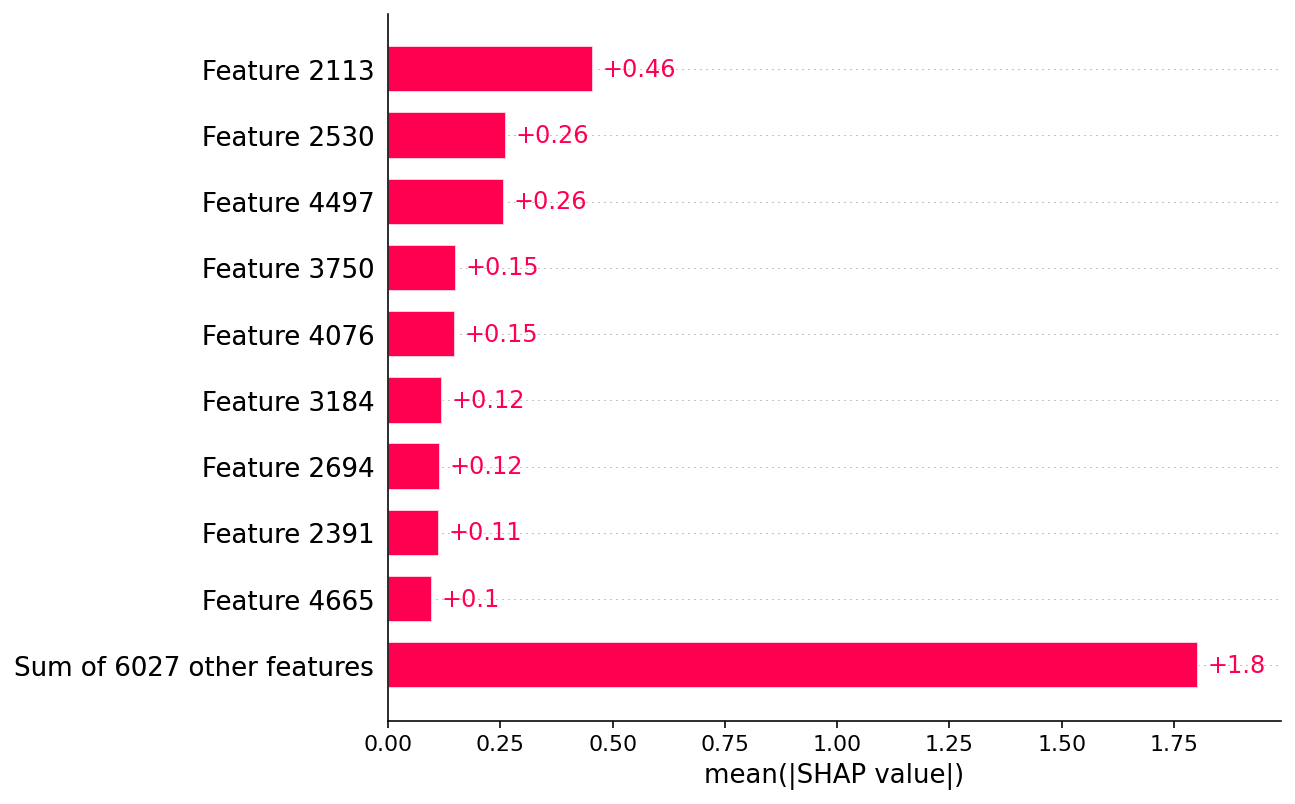

In [14]:
# Getting data into correct format for fitting XGBoost model
X_trainNPArray = np.array(X_train); X_testNPArray = np.array(X_test)
y_trainNPArray = np.array(y_train); y_testNPArray = np.array(y_test)

X_train_xgb = np.vstack(X_trainNPArray); X_test_xgb = np.vstack(X_testNPArray)
y_train_xgb = np.vstack(y_trainNPArray); y_test_xgb = np.vstack(y_testNPArray)

# Instantiating and fitting the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=SEED, use_label_encoder=False)
xgb_model.fit(X_train_xgb, y_train_xgb)

XNPArray = np.array(X); X_xgb = np.vstack(XNPArray)
# Explaining the model's predictions using SHAPs explainer function
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_xgb)

# Visualising the predictor's explanation with a bar plot of ascending importance (fingers crossed...)
ax = shap.plots.bar(shap_values)

The plots above indicate that features 2113, 2503, 4497, 3750, 4076, 3184, 2694, 2391 and 4665 are to be followed up on, by extracting the AA they correspond to and finding the frequency of this residue in the 206 active IRED sequences.

In [20]:
# A loop which generates the AA position of each important feaure. Divide by 6 then round down.
import math

features = [2113, 2503, 4497, 3750, 4076, 3184, 2694, 2391, 4665]
important_aa = []
for i in features:
    x = math.floor(i/6)
    important_aa.append(x)

In [752]:
print(important_aa)

[352, 398, 417, 449, 530, 625, 679, 749, 777]


In [22]:
# Creating a dictionary to enable the identification and frequency of important AA residues according to CHAP
keyset = list(labels.keys())
aa_dict = {}
for key in keyset:
    for i, sequence in enumerate(align_array):
        if key == str(i):
            aa_dict[key] = sequence

In [23]:
residue_df = pd.DataFrame.from_dict(aa_dict, orient='index')
residue_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,996,997,998,999,1000,1001,1002,1003,1004,1005
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [63]:
literature = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']
for new_entry in literature:
    for ired_name, sequence in seqs.items():
        if new_entry == ired_name:
            aa_dict[new_entry] = sequence

In [123]:
residue_df = pd.DataFrame.from_dict(aa_dict, orient='index')

In [318]:
# List of strings of important residue positions
aa_str = []
for aa in important_aa:
    aa_str.append(str(aa))
    
# Concatenating string of residue position with 'Position ' to input into finding the AA frequency
aa_position_str = []
for aa in aa_str:
    pos = 'position '
    aa_position_str.append(pos + aa)

In [240]:
from collections import Counter

position_352 = []
for key in aa_dict.keys():
    all_seqs = aa_dict[key]
    position_352.append(all_seqs[351])

residue_df['position 352'] = position_352

In [241]:
position_417 = []
for key in aa_dict.keys():
    all_seqs = aa_dict[key]
    position_417.append(all_seqs[416])

residue_df['position 417'] = position_417

In [242]:
position_749 = []
for key in aa_dict.keys():
    all_seqs = aa_dict[key]
    position_749.append(all_seqs[748])

residue_df['position 749'] = position_749

In [243]:
position_625 = []
for key in aa_dict.keys():
    all_seqs = aa_dict[key]
    position_625.append(all_seqs[624])

residue_df['position 625'] = position_625

In [244]:
position_679 = []
for key in aa_dict.keys():
    all_seqs = aa_dict[key]
    position_679.append(all_seqs[678])

residue_df['position 679'] = position_679

In [245]:
position_530 = []
for key in aa_dict.keys():
    all_seqs = aa_dict[key]
    position_530.append(all_seqs[529])

residue_df['position 530'] = position_530

In [246]:
position_449 = []
for key in aa_dict.keys():
    all_seqs = aa_dict[key]
    position_449.append(all_seqs[448])

residue_df['position 449'] = position_449

In [247]:
position_398 = []
for key in aa_dict.keys():
    all_seqs = aa_dict[key]
    position_398.append(all_seqs[397])

residue_df['position 398'] = position_398

In [248]:
position_777 = []
for key in aa_dict.keys():
    all_seqs = aa_dict[key]
    position_777.append(all_seqs[776])

residue_df['position 776'] = position_777

In [126]:
#residue_df = residue_df[aa_position_str]

In [100]:
ired_b = ['MPDNPSTKGRMMRNQQAEHTPVTVIGLGLMGQALAGAFLGAGHPTTVWNRTAAKAEPLVARGAKSAGSVAEAVAASPLVVVCVSDYDAVHALLDPLDGTALQGRTLVNLTSGTSAQARERAAWADGRGADYLDGAILAGPAAIGTADAVVLLSGPRSAFDPHASALGGLGAGTTYLGADHGLASLYDAAGLVMMWSILNGFLQGAALLGTAGVDATTFAPFITQGIGTVADWLPGYARQIDDGAYPADDAAIDTHLATMEHLIHESEFLGVNAELPRFIKALADRAVADGHGGSGYPALIEQFRTHSGK']

In [127]:
(ired_b[0])[186]

'D'

In [138]:
(ired_b[0])[190]

'L'

In [187]:
print((ired_b[0])[136]); print((ired_b[0])[190])

L
L


In [172]:
(ired_b[0])[182:190]

'ASLYDAAG'

In [185]:
(aa_dict['B'])[601]

'D'

In [193]:
(aa_dict['B'])[597:605]

array(['A', 'S', 'L', 'Y', 'D', 'A', 'A', 'G'], dtype='<U1')

In [229]:
#for i in aa_dict:
    #print((aa_dict[i])[601])

In [195]:
ired_k = ['MNTKSVTVIGLGPMGQAMADAYLDGGYEVTVWNRTAARADRLVARGARRAPTVEAALTANDLVVLSLTDYDAMYAILEQAPSAALAGRTVANLTSDTPEKARQAAAWLAERGAVQITGGVQVPPPGIGKPGATTYYSGPEDAIEAHRPALEVLTEIDHLGEDPGLAALFYQIGMDMFWTGILSYVHAQAVAEANGISAERFLPNAVKTMDFRYFLEFYAPRIAAGNHEGDVDRLAMGVASMEHVLHTVEASGVDGSLPAAVLDVFRRGVAAGHGQDSLTSLIKVLKR']

In [615]:
(ired_b[0])[135:140]

'ILAGP'

In [622]:
(aa_dict['B'])[514]

'G'

In [591]:
#for i in aa_dict:
    #print((aa_dict[i])[514])

In [221]:
(ired_k[0])[176]

'F'

In [306]:
(ired_k[0])[173:179]

'F'

In [305]:
(aa_dict['K'])[600:609]

array(['F', 'Y', 'Q', 'I', 'G', 'M', 'D', 'M', 'F'], dtype='<U1')

In [ ]:
#for i in aa_dict:
    #print((aa_dict[i])[609])

In [457]:
ired_i = ['MSKQSVTVIGLGPMGQAMVNTFLDNGHEVTVWNRTASKAEALVARGAVLAPTVEDALSANELIVLSLTDYDAVYAILEPVTGSLSGKVIANLSSDTPDKAREAAKWAAKHGAKHLTGGVQVPPPLIGKPESSTYYSGPKDVFDAHEDTLKVLTNADYRGEDAGLAAMYYQAQMTIFWTTMLSYYQTLALGQANGVSAKELLPYATMMTSMMPHFLELYAQHVDSADYPGDVDRLAMGAASVDHVLHTHQDAGVSTVLPAAVAEIFKAGMEKGFAENSFSSLIEVLKKPAV']

In [458]:
(ired_i[0])[168]

'Y'

In [459]:
(ired_i[0])[165:170]

'AMYYQ'

In [469]:
(aa_dict['I'])[600]

'Y'

In [233]:
important_aa.sort()
important_aa

[352, 398, 417, 449, 530, 625, 679, 749, 777]

In [623]:
position_609 = []
for i in aa_dict:
    position_609.append((aa_dict[i])[608])
    
position_602 = []
for i in aa_dict:
    position_602.append((aa_dict[i])[601])
    
position_515 = []
for i in aa_dict:
    position_515.append((aa_dict[i])[514])

position_601 = []
for i in aa_dict:
    position_601.append((aa_dict[i])[600])

In [624]:
df = pd.read_excel('Prelim data.xlsx', engine='openpyxl')
df.dropna(subset=['enantiomer binary'], inplace=True)
df.set_index('IRED', inplace=True)
df.shape

(219, 4)

In [625]:
df['position 352'] = position_352
df['position 417'] = position_417
df['position 749'] = position_749
df['position 625'] = position_625
df['position 679'] = position_679
df['position 530'] = position_530
df['position 449'] = position_449
df['position 398'] = position_398
df['position 777'] = position_777

df['position 602'] = position_602
df['position 515'] = position_515
df['position 609'] = position_609
df['position 601'] = position_601

In [626]:
#df.drop(columns='position 537', inplace=True)
#df.drop(columns='Ired source', inplace=True)
df.drop(columns='Sequence', inplace=True)
df.head(2)

,Enantiomer,enantiomer binary,ired source,position 352,position 417,position 749,position 625,position 679,position 530,position 449,position 398,position 777,position 602,position 515,position 609,position 601
IRED,,,,,,,,,,,,,,,,
1,S,1.0,Metagenomic,A,-,-,K,D,A,T,I,L,D,Y,F,V
2,S,1.0,Metagenomic,E,-,-,K,D,A,T,I,L,D,Y,F,V


In [627]:
r_df = df[df['Enantiomer'] == 'R']
s_df = df[df['Enantiomer'] == 'S']

In [628]:
import matplotlib.pyplot as plt

In [629]:
def meta_position_plot(position):
    sns.set(rc={'figure.figsize': (4,4)})
    sns.set(font_scale=1)
    sns.set_style('white')
    %config InlineBackend.figure_format = 'retina'
    ax = sns.countplot(data=r_df, y=position, order=meta_r_df[position].value_counts().index[:5])

    total = len(meta_r_df[position])
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
        plt.title('Metagenomic ' + position + ' R entries')
    
    fig = ax.get_figure()
    title = 'Metagenomic ' + position + ' R entries'
    fig.savefig(str(title)+ '.png')
    plt.show ()

    ax_1 = sns.countplot(data=meta_s_df, y=position, order=meta_s_df[position].value_counts().index[:5])

    total = len(meta_s_df[position])
    for p in ax_1.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax_1.annotate(percentage, (x, y))
        plt.title('Metagenomic ' + position + ' S entries')
    
    fig = ax_1.get_figure()
    title1 = 'Metagenomic ' + position + ' S entries'
    fig.savefig(str(title1)+ '.png')
    plt.show()

In [630]:
def lit_position_plot(position):
    sns.set(rc={'figure.figsize': (4,4)})
    sns.set(font_scale=1)
    sns.set_style('white')
    %config InlineBackend.figure_format = 'retina'
    ax = sns.countplot(data=lit_r_df, y=position, order=lit_r_df[position].value_counts().index[:5])

    total = len(lit_r_df[position])
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
        plt.title('Literature ' + position + ' R entries')
    
    fig = ax.get_figure()
    title = 'Literature ' + position + ' R entries'
    fig.savefig(str(title)+ '.png')
    plt.show ()

    ax_1 = sns.countplot(data=lit_s_df, y=position, order=lit_s_df[position].value_counts().index[:5])

    total = len(lit_s_df[position])
    for p in ax_1.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax_1.annotate(percentage, (x, y))
        plt.title('Literature ' + position + ' S entries')
    
    fig = ax_1.get_figure()
    title1 = 'Literature ' + position + ' S entries'
    fig.savefig(str(title1)+ '.png')
    plt.show()

In [633]:
# List of strings of important residue positions
aa_str = []
for aa in important_aa:
    aa_str.append(str(aa))
    
# Concatenating string of residue position with 'Position ' to input into finding the AA frequency
aa_position_str = []
for aa in aa_str:
    pos = 'position '
    aa_position_str.append(pos + aa)

In [634]:
new_positions = ['position 602', 'position 515', 'position 609', 'position 601']
for new_position in new_positions:
    aa_position_str.append(new_position)

In [635]:
aa_position_str

['position 352',
 'position 398',
 'position 417',
 'position 449',
 'position 530',
 'position 625',
 'position 679',
 'position 749',
 'position 777',
 'position 602',
 'position 515',
 'position 609',
 'position 601']

In [636]:
lit_df = df[206:]
lit_r_df = lit_df[lit_df['Enantiomer'] == 'R']
lit_s_df = lit_df[lit_df['Enantiomer'] == 'S']

meta_df = df[:206]
meta_r_df = meta_df[meta_df['Enantiomer'] == 'R']
meta_s_df = meta_df[meta_df['Enantiomer'] == 'S']

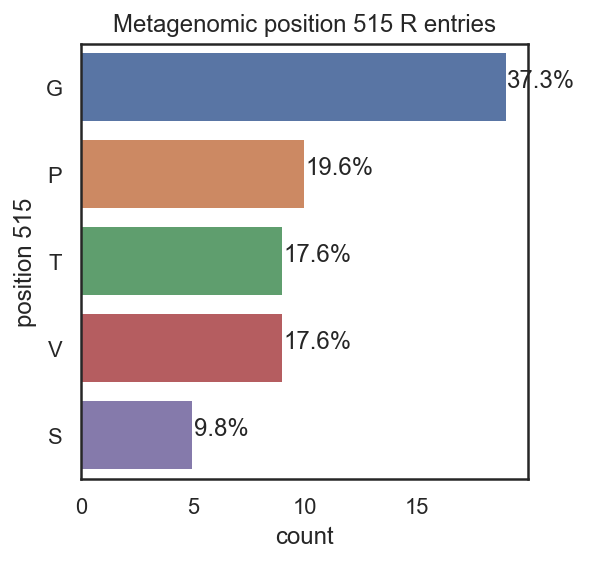

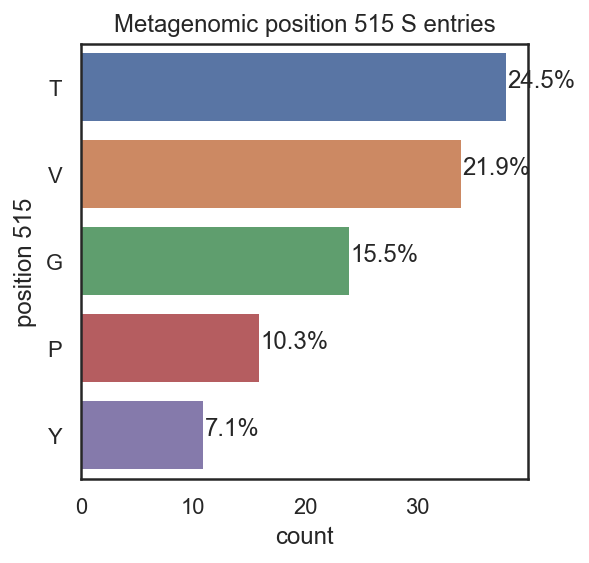

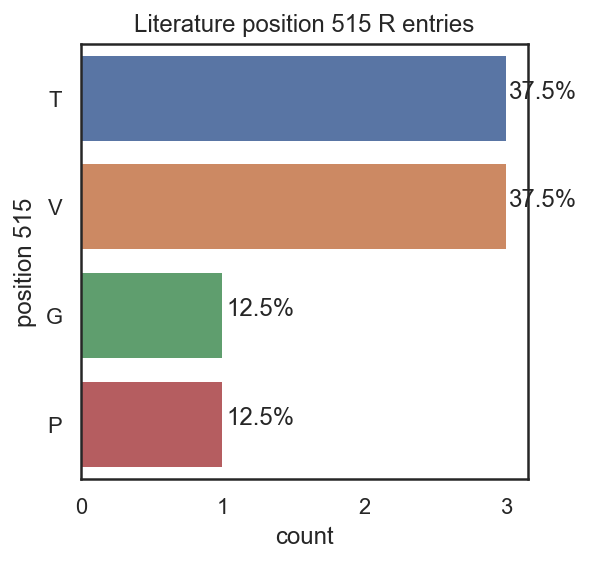

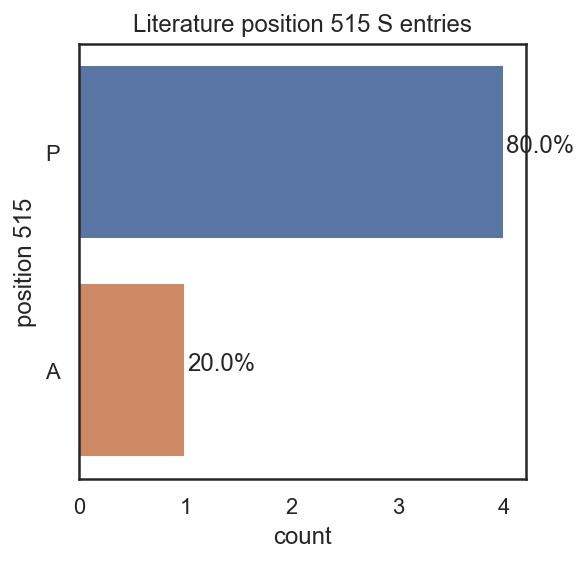

In [637]:
meta_position_plot(aa_position_str[10])
lit_position_plot(aa_position_str[10])

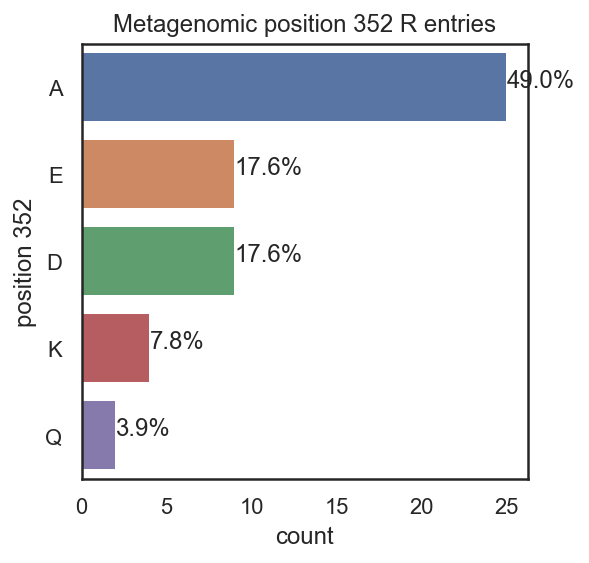

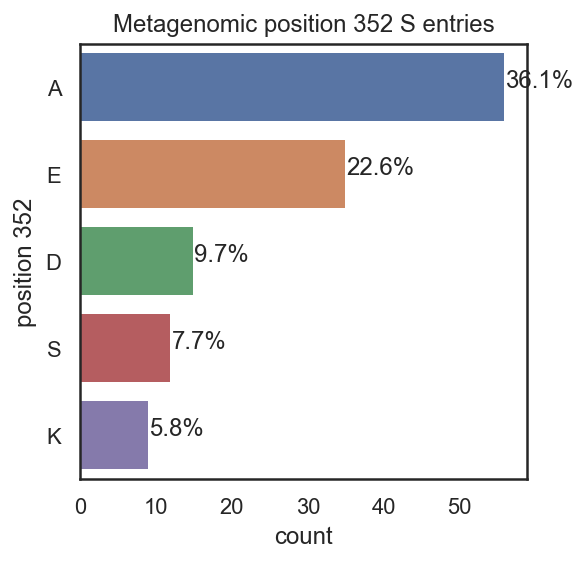

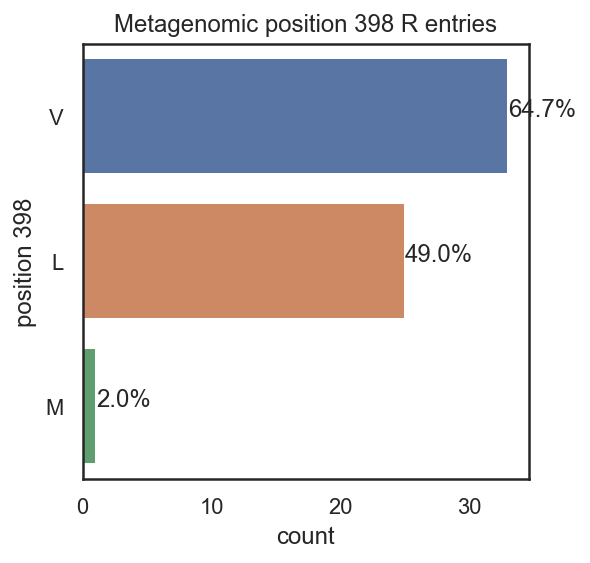

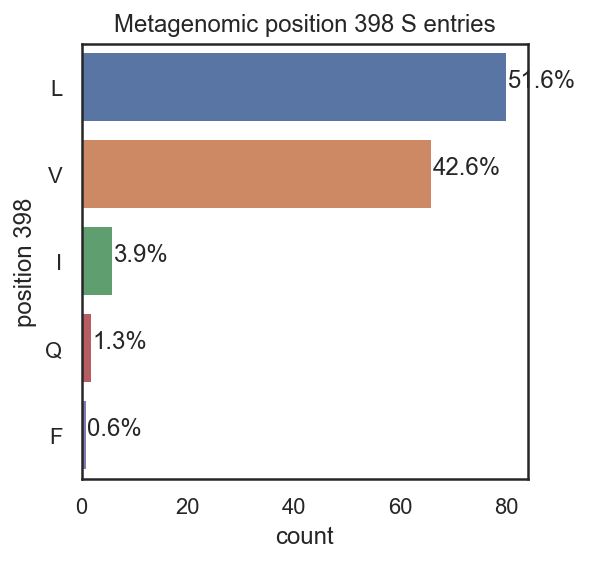

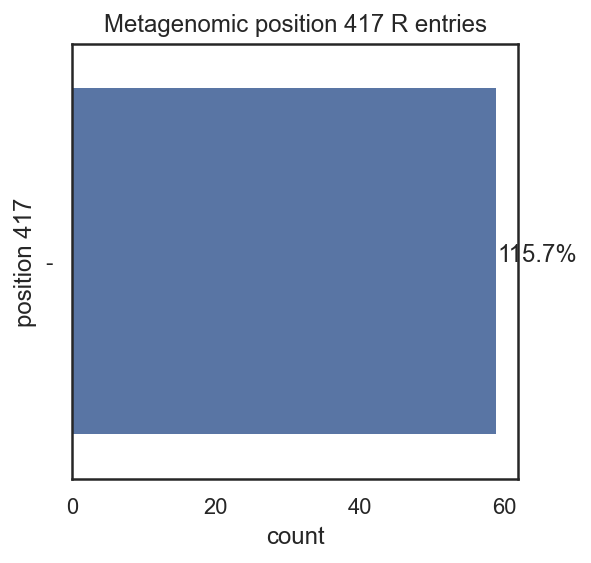

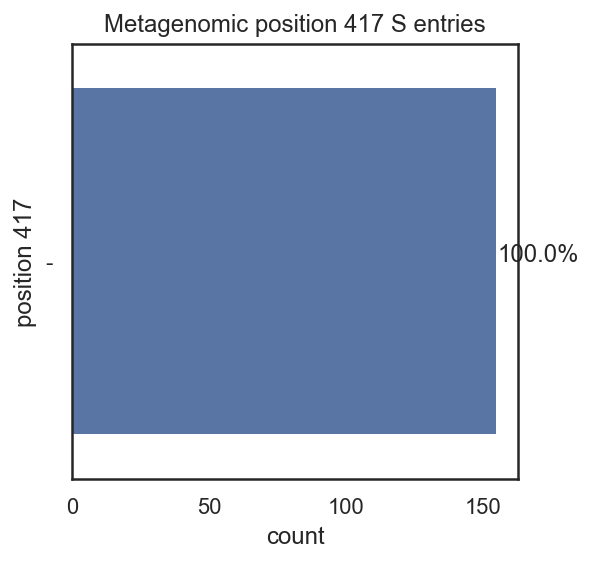

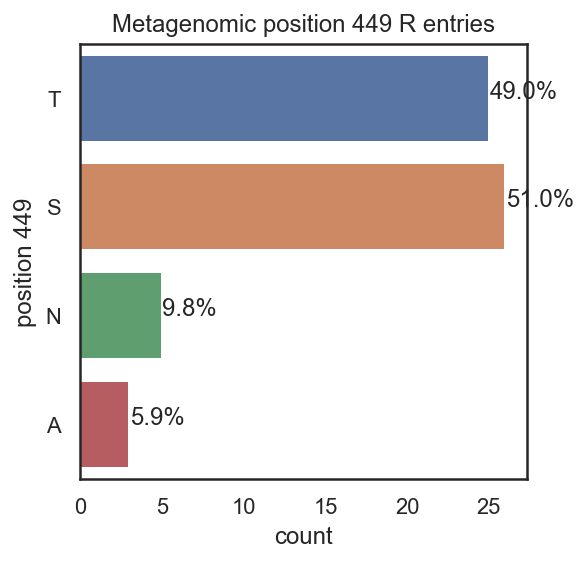

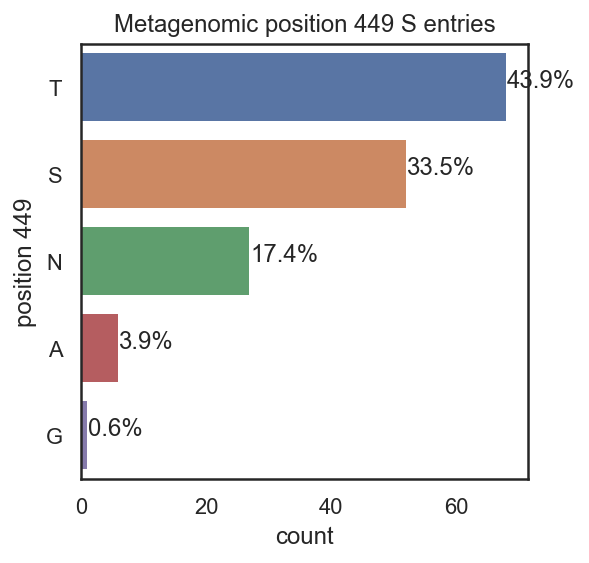

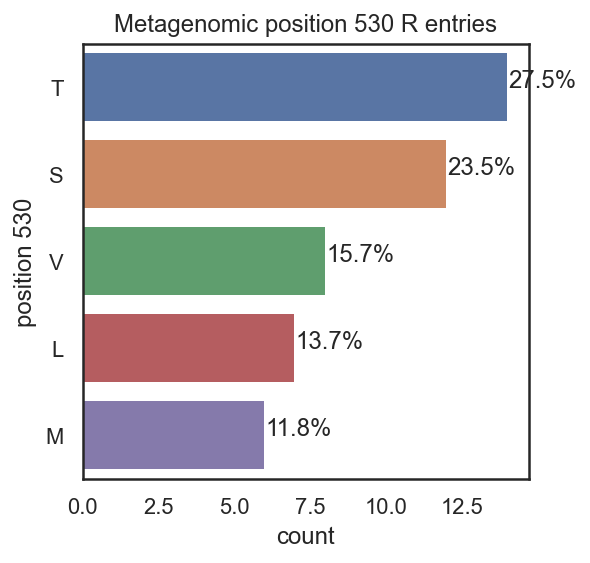

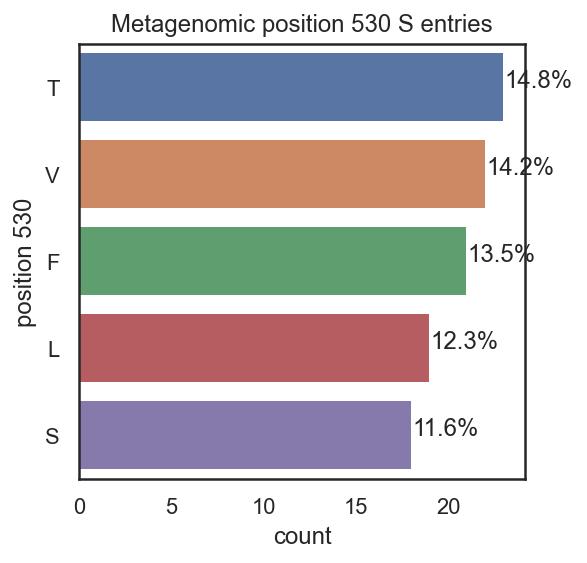

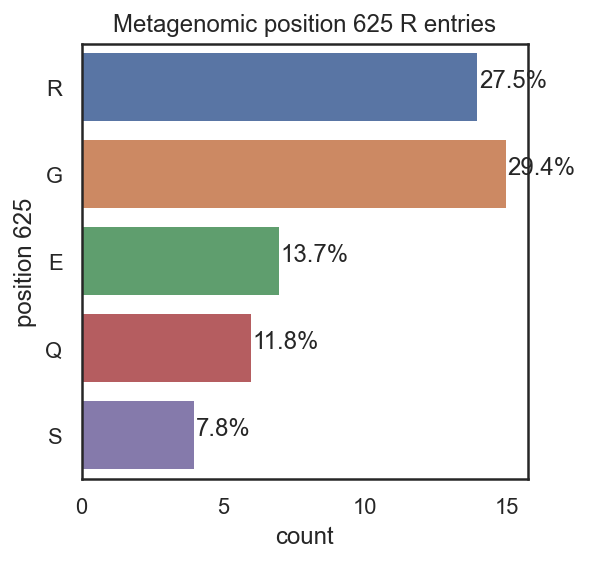

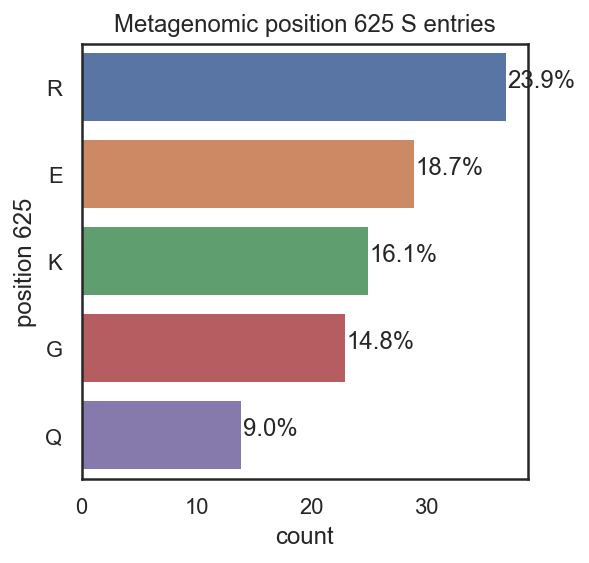

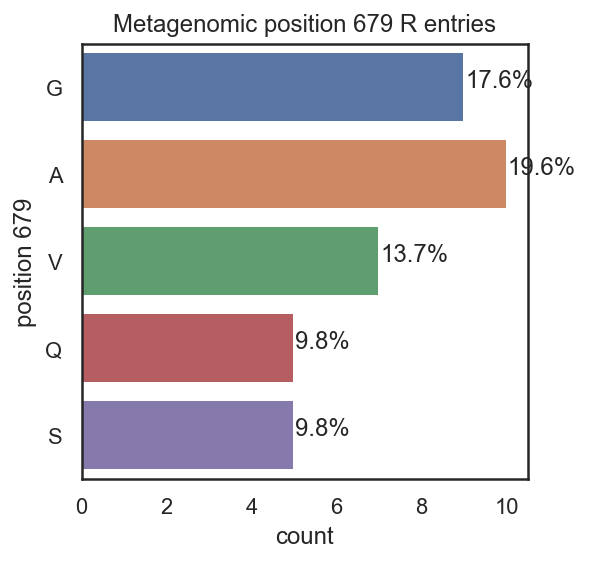

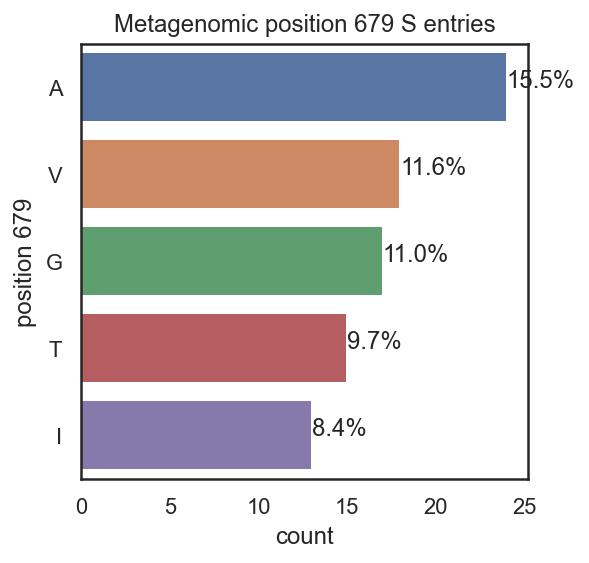

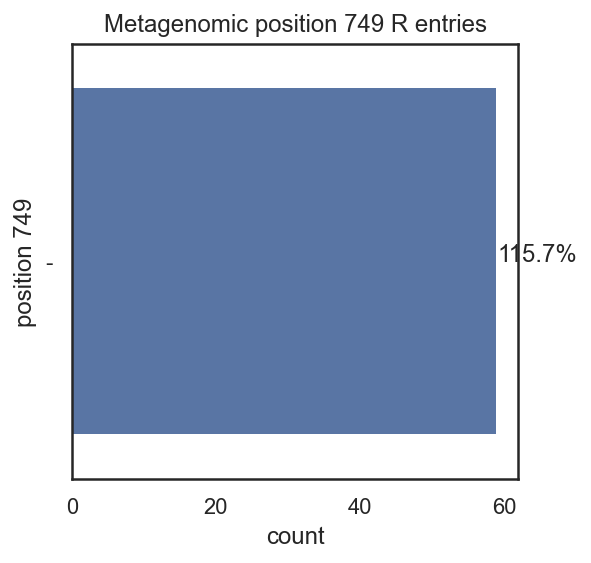

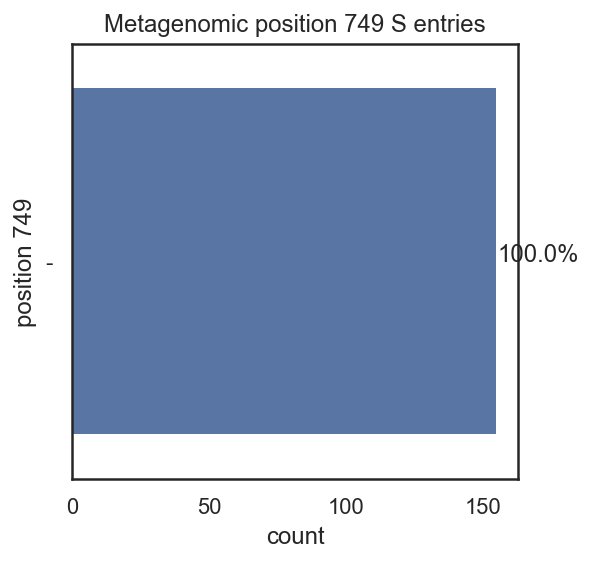

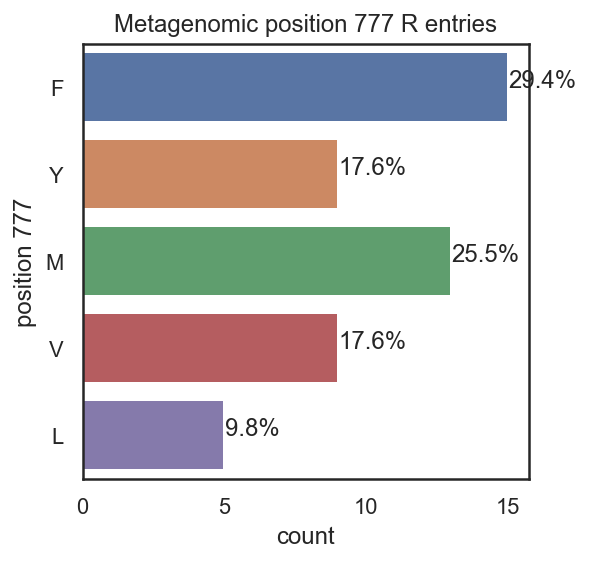

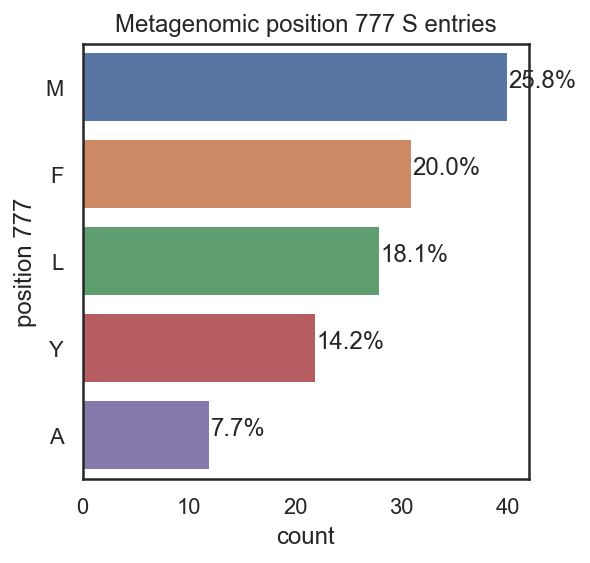

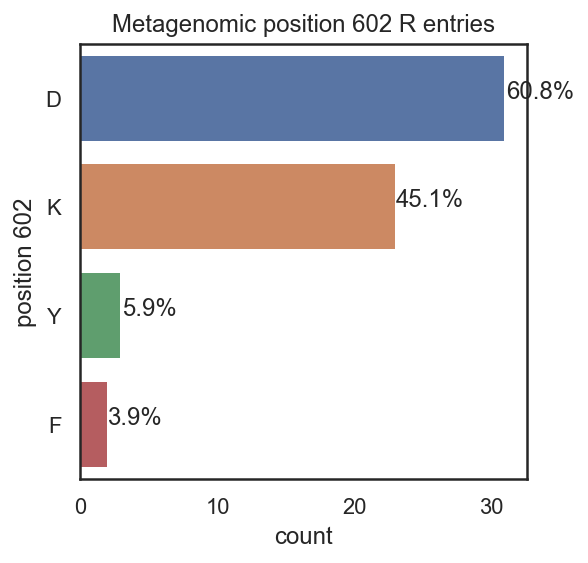

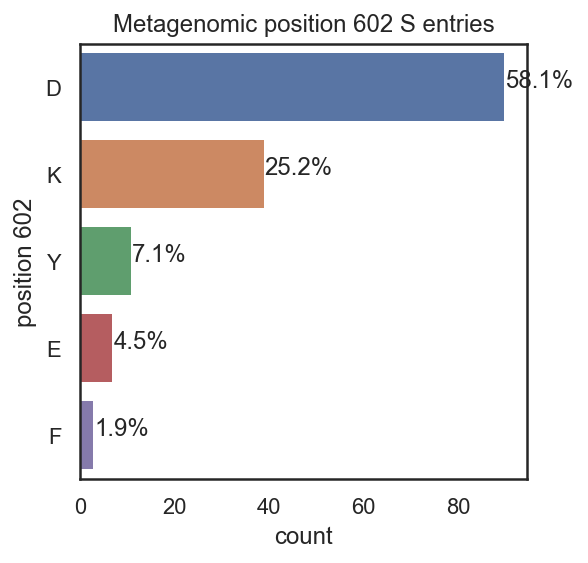

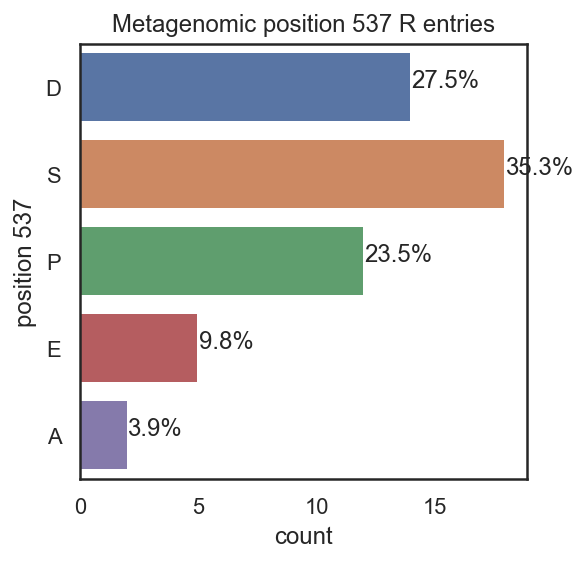

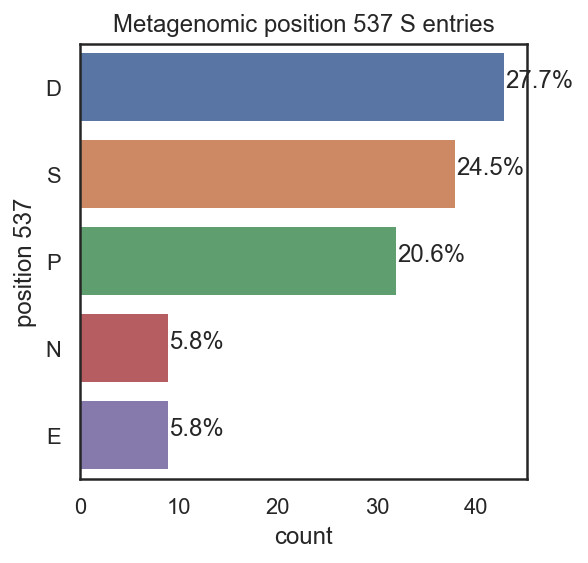

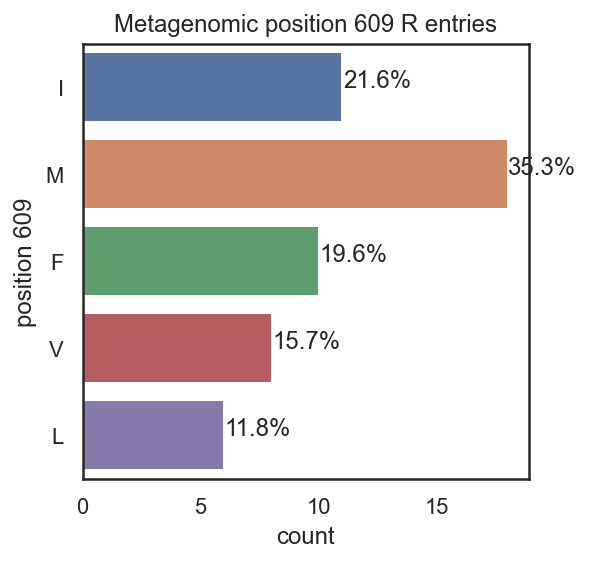

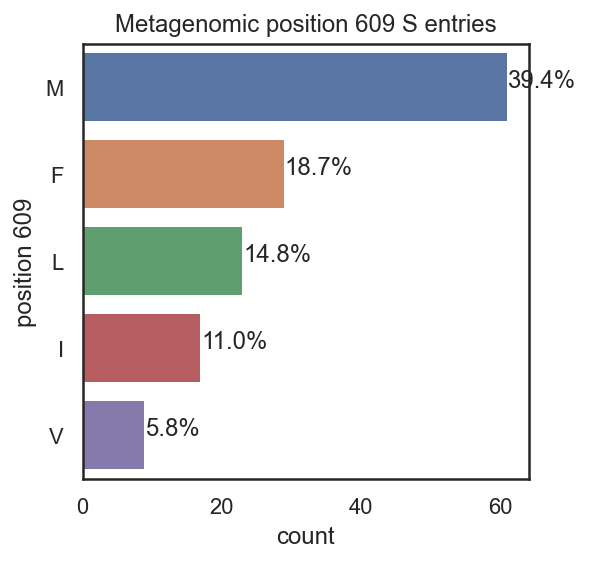

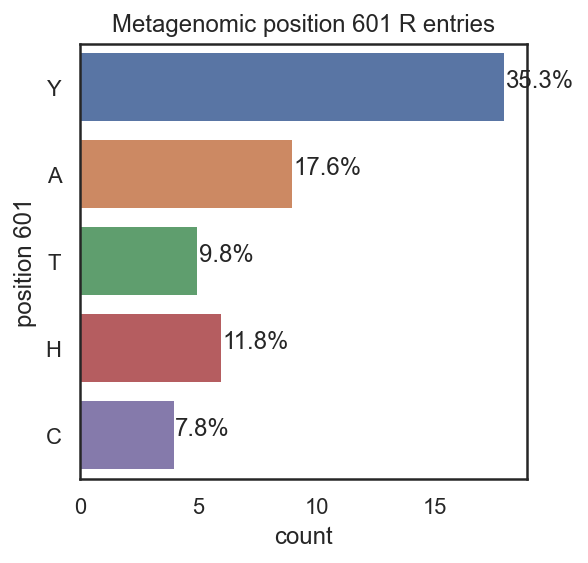

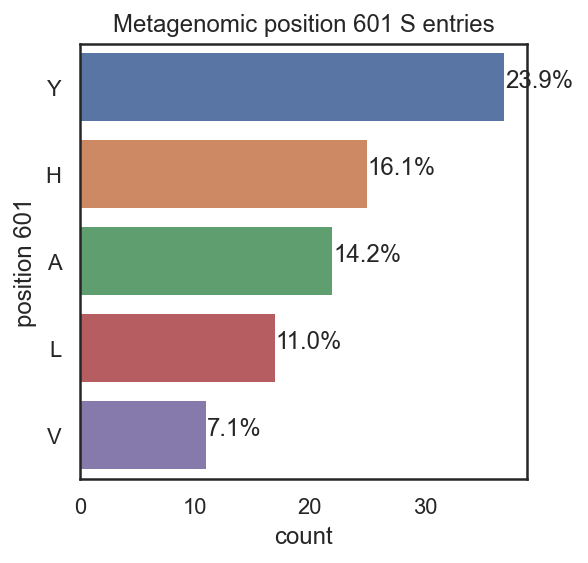

In [556]:
for position in aa_position_str:
    meta_position_plot(position)

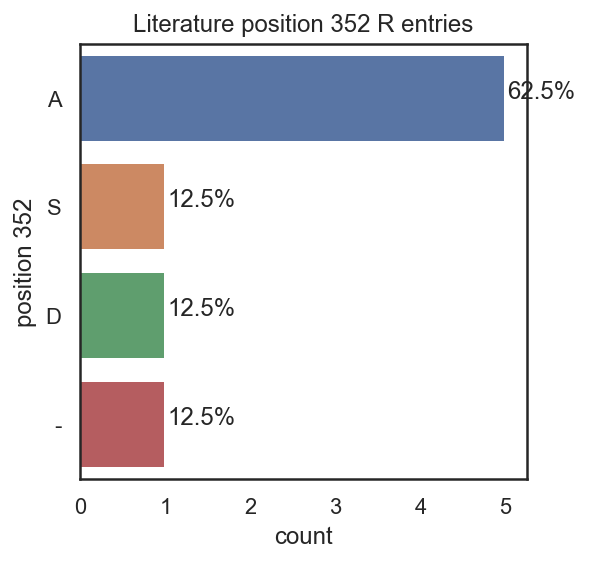

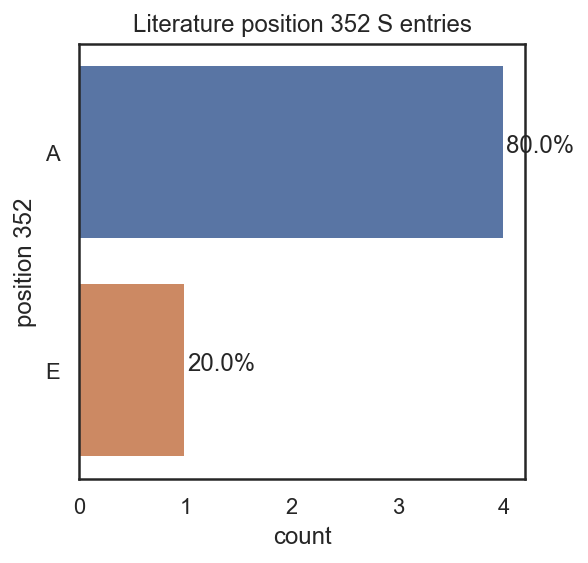

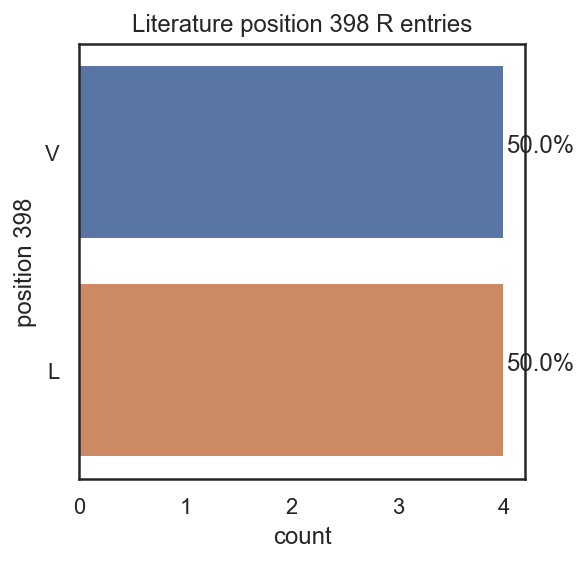

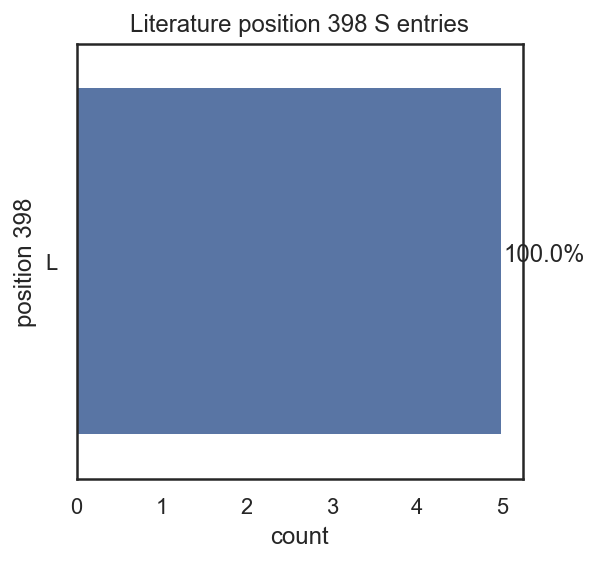

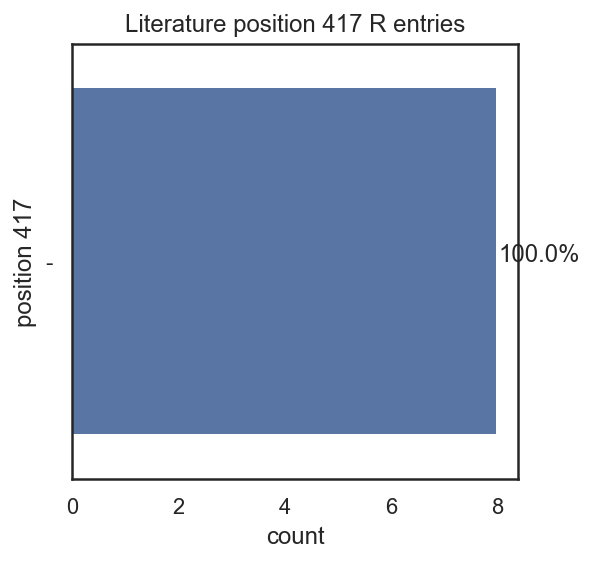

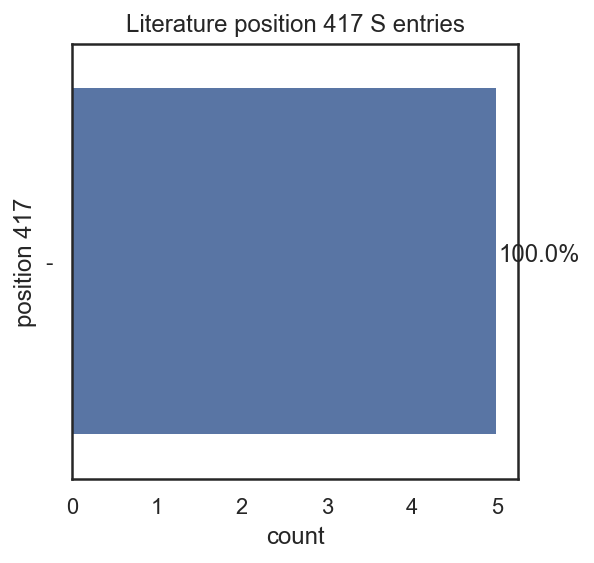

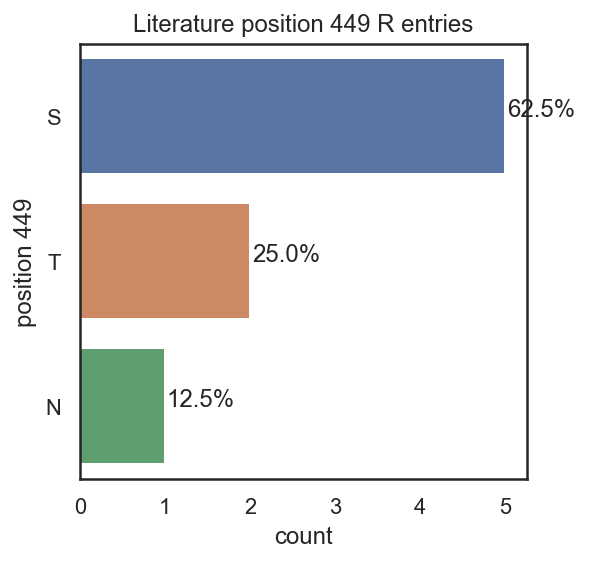

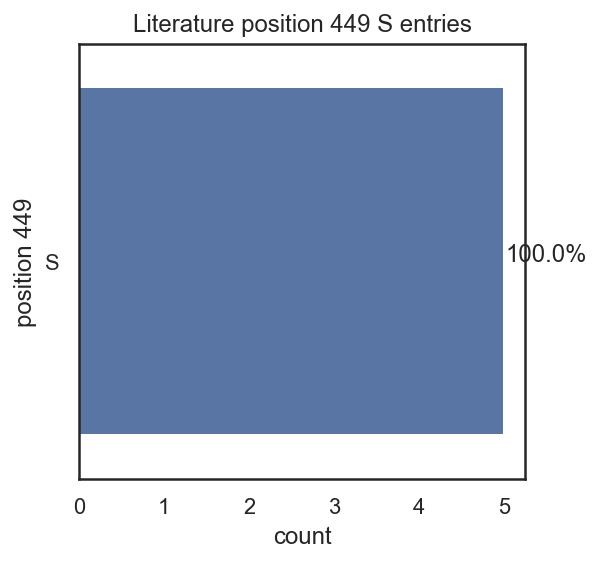

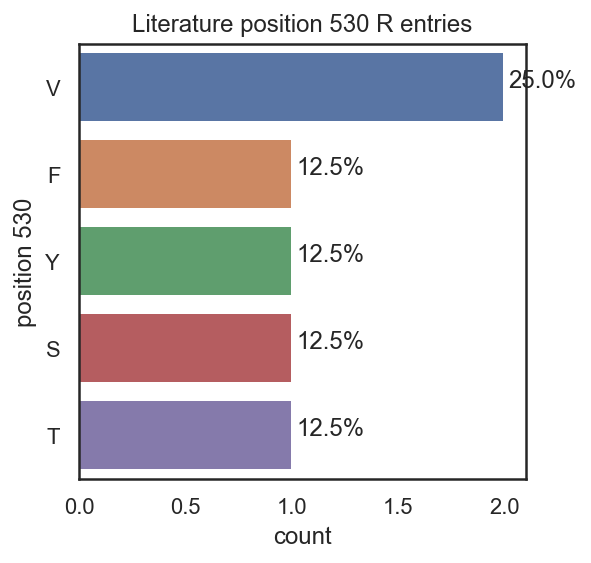

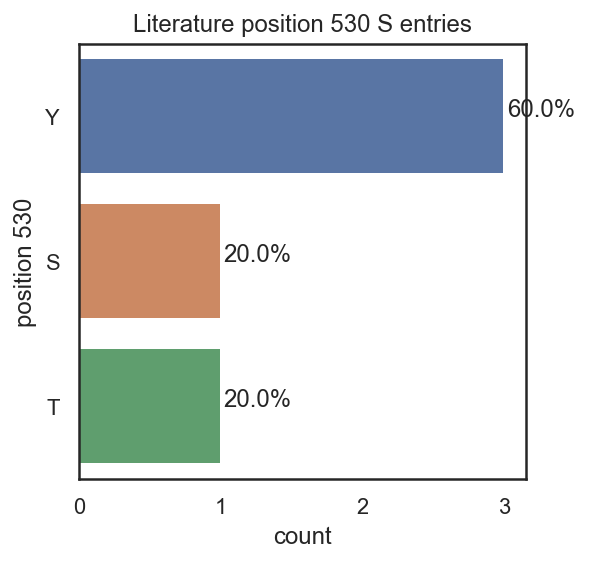

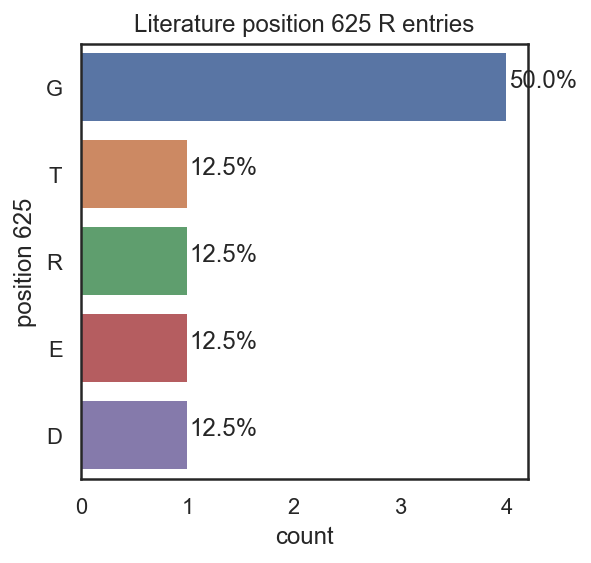

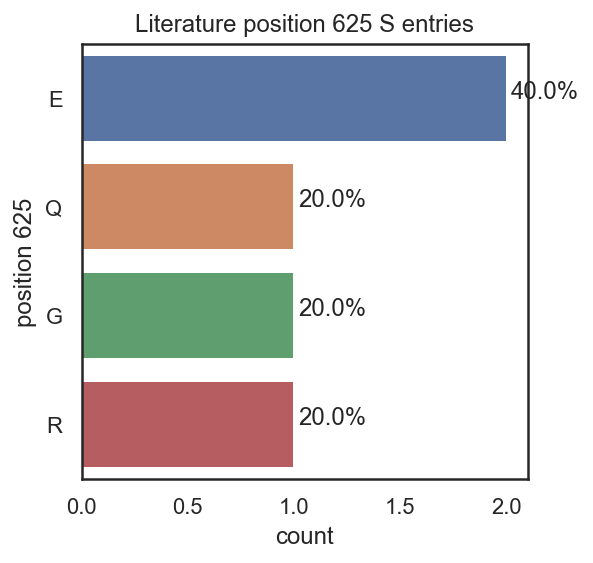

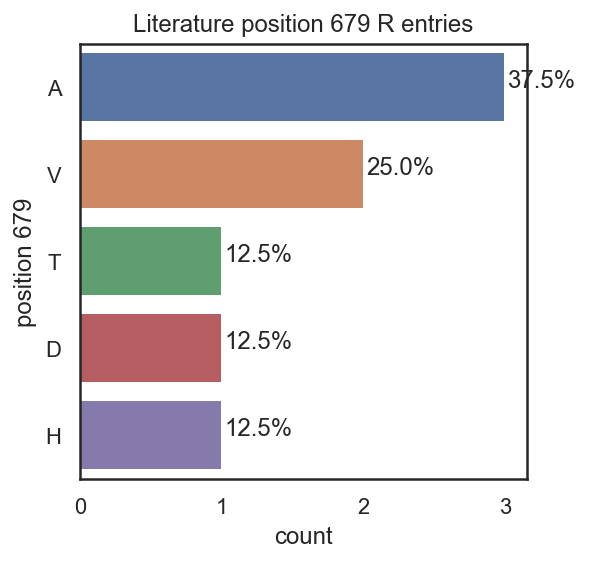

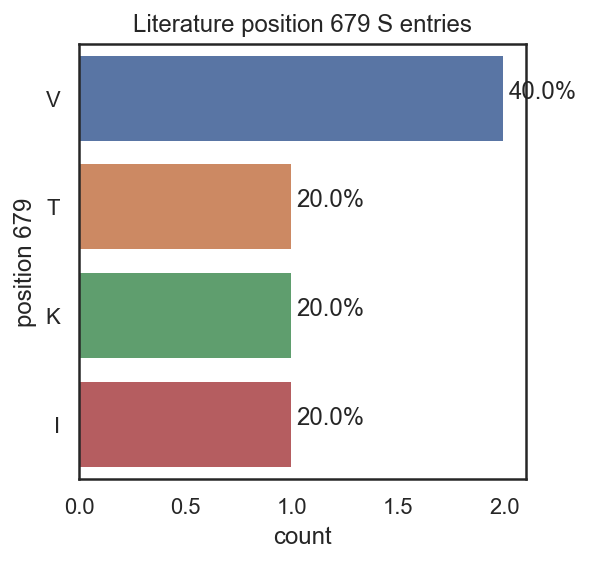

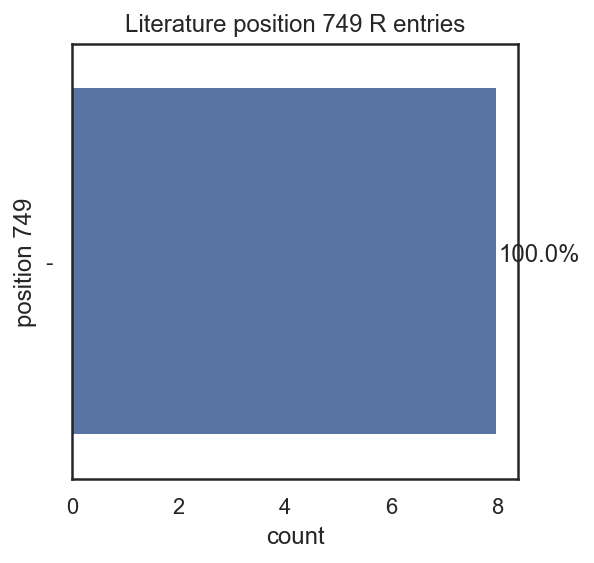

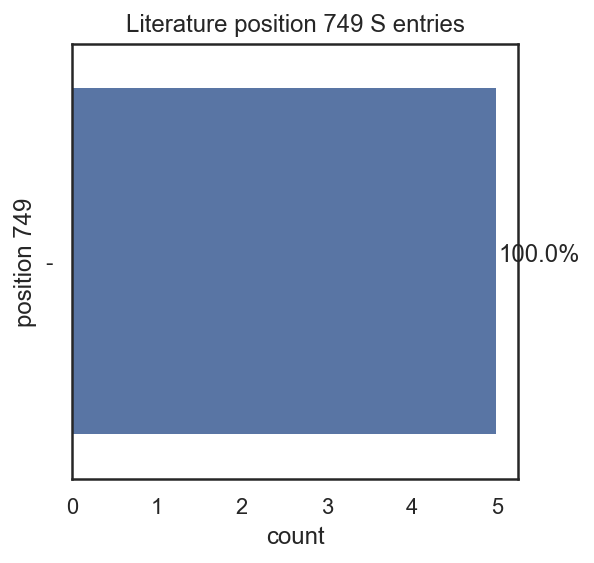

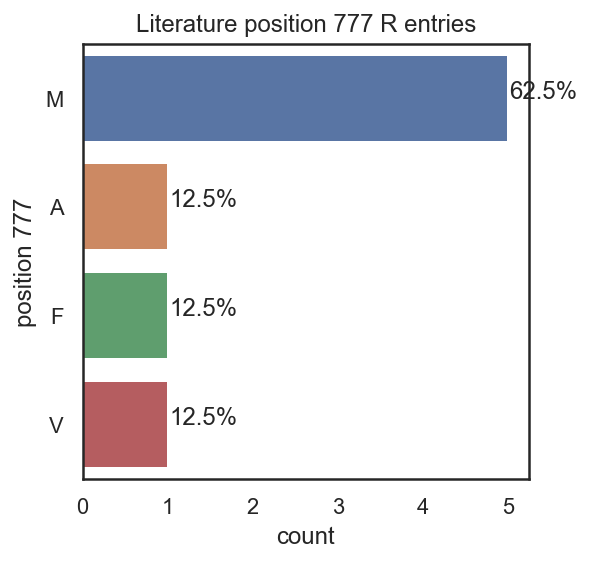

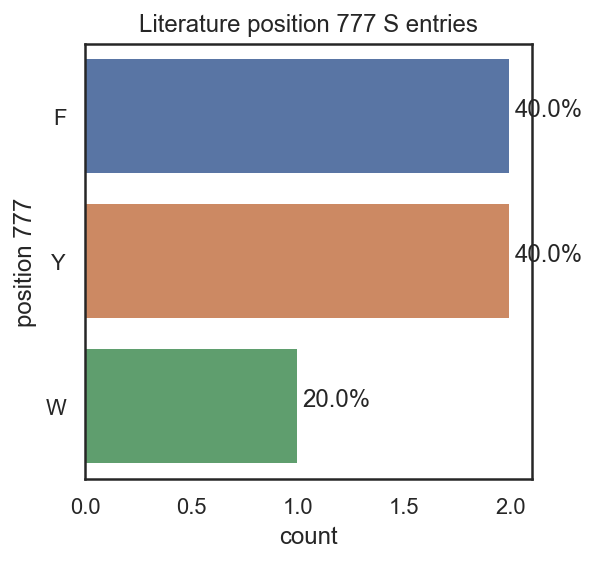

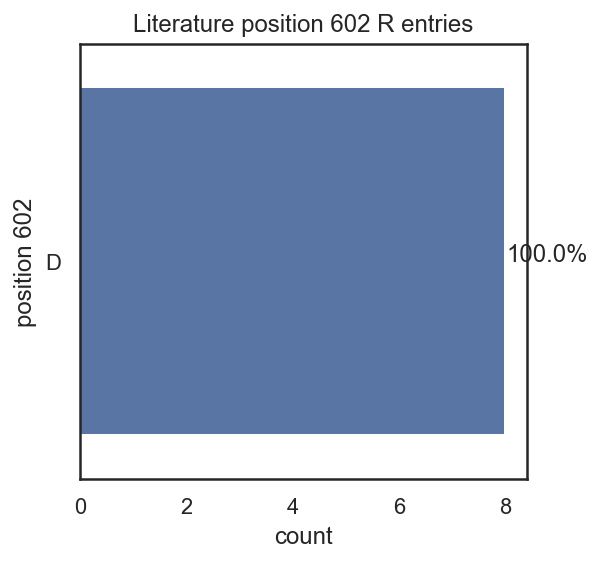

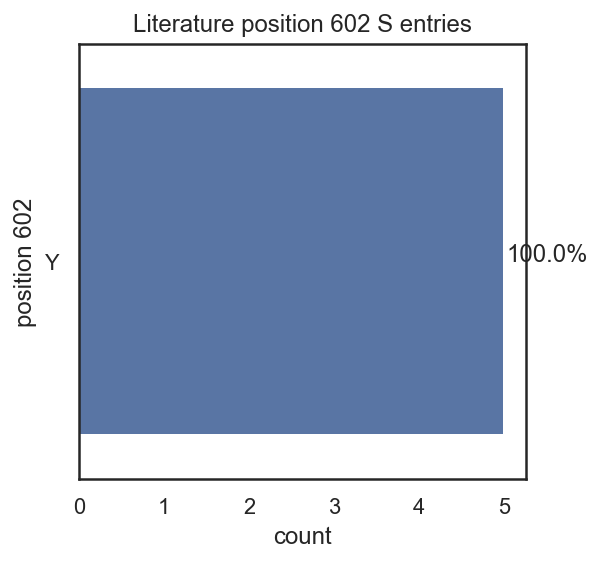

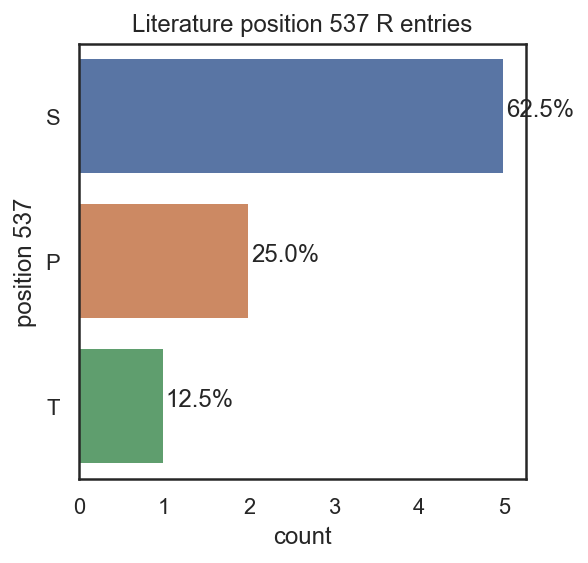

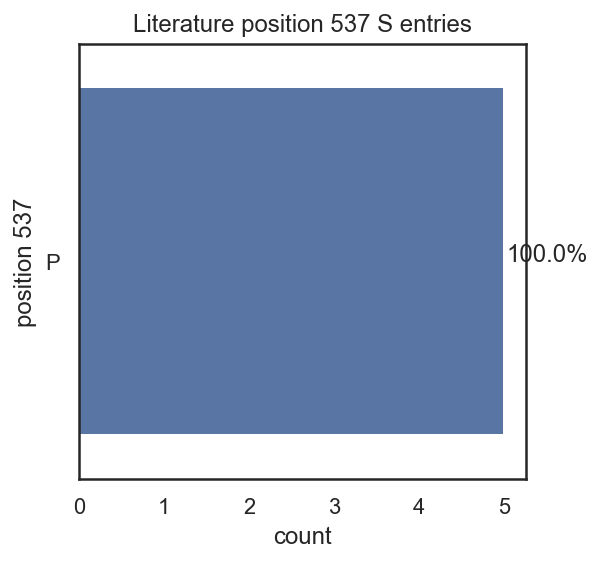

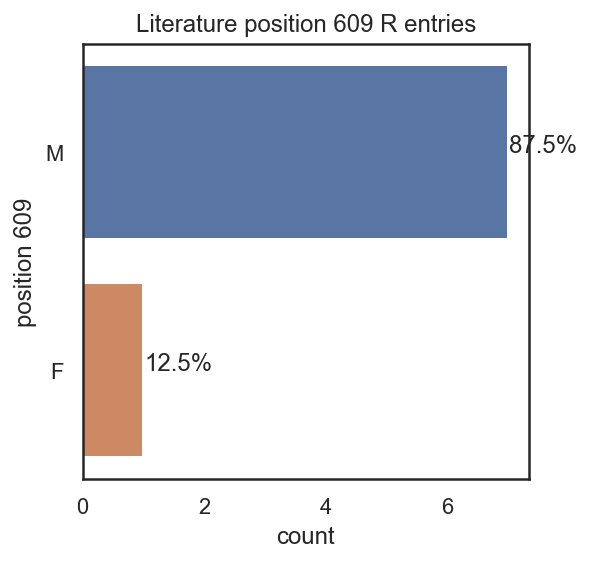

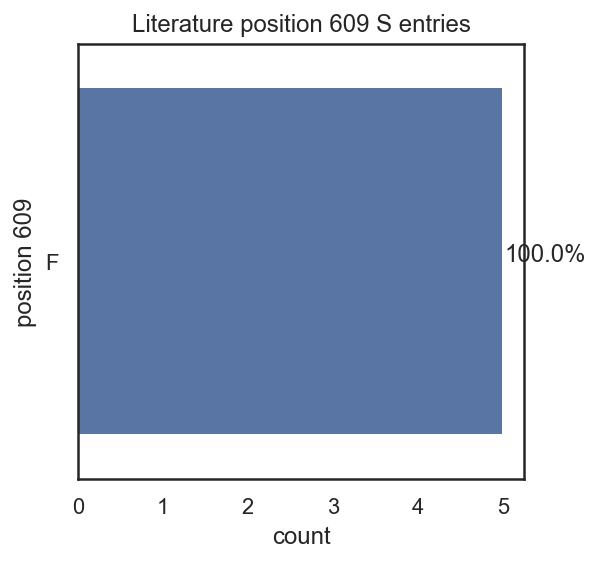

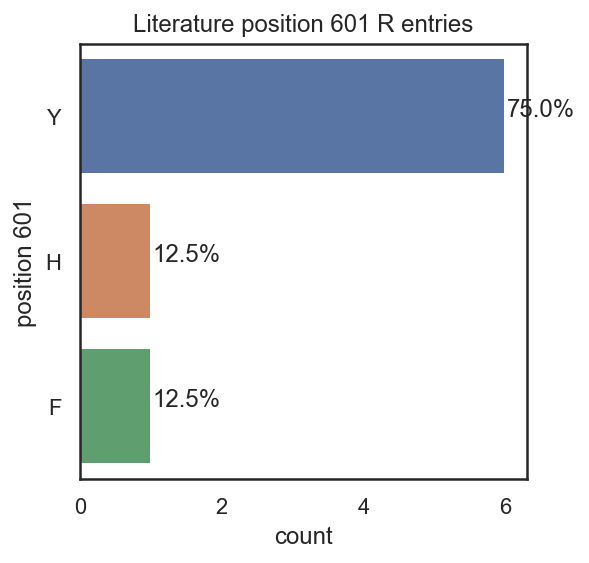

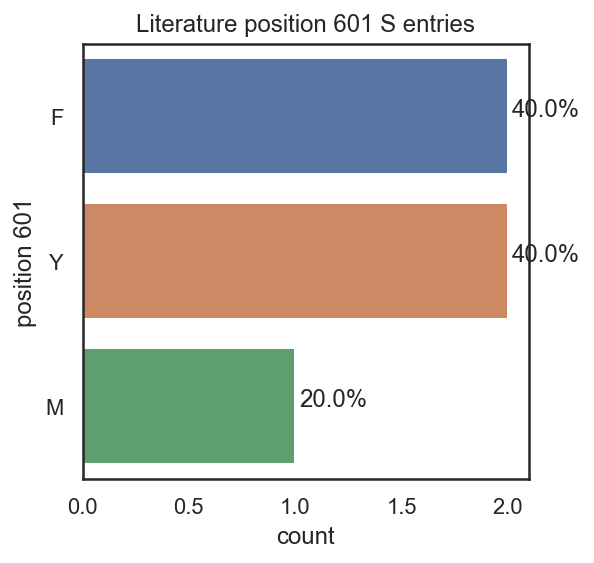

In [561]:
for position in aa_position_str:
    lit_position_plot(position)

In [388]:
feat_active = {}
for key in aa_dict.keys():
    if key in feat_seqs.keys():
        feat_active[key] = feat_seqs[key]

In [394]:
len(aa_dict)

219

In [395]:
descrip_list = []
for ired_name in aa_dict:
    descrip_list.append(feat_active.get(ired_name))

X = descrip_list

In [641]:
type_df = pd.read_excel('Prelim data.xlsx', engine='openpyxl')
type_df.dropna(subset=['enantiomer binary'], inplace=True)

type_df.tail(2)
source = list(type_df['ired source'])
enantiomer = list(type_df['Enantiomer'])
df['ired source'] = source
df.tail(2)

,Enantiomer,enantiomer binary,ired source,position 352,position 417,position 749,position 625,position 679,position 530,position 449,position 398,position 777,position 602,position 515,position 609,position 601
IRED,,,,,,,,,,,,,,,,
L,S,1.0,Literature,E,-,-,E,V,Y,S,L,W,Y,A,F,Y
M,S,1.0,Literature,A,-,-,R,K,Y,S,L,Y,Y,P,F,F


In [646]:
sns.set(rc={'figure.figsize': (7,7)})
sns.set(font_scale=1.5)
sns.set_style('ticks')
%config InlineBackend.figure_format = 'retina'

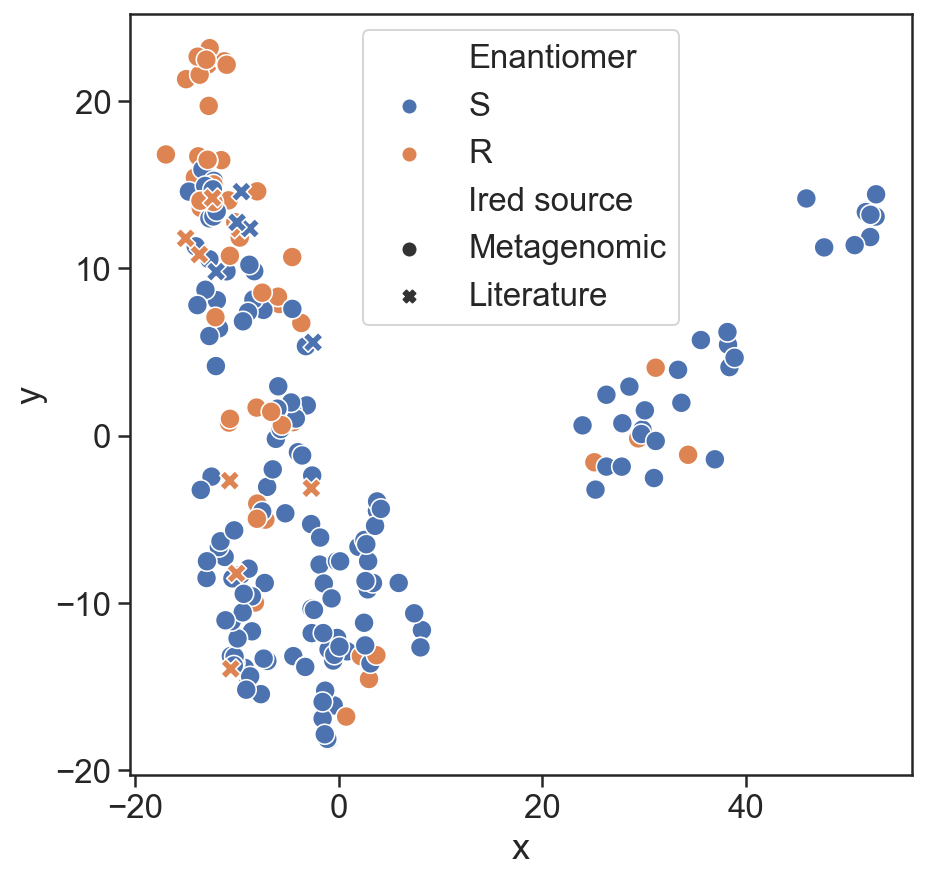

In [648]:
# 2D PCA plot with metagenomic and literature IRED enzymes
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
crds = pca.fit_transform(X)

pca_df = pd.DataFrame(crds, columns=['x', 'y'])
pca_df['Ired source'] = source
pca_df['Enantiomer'] = enantiomer

ax = sns.scatterplot(data=pca_df, x='x', y='y', hue='Enantiomer', style='Ired source', s=100)
plt.legend(loc='upper center')
fig = ax.get_figure()
fig.savefig("Meta and lit pca.png")

In [713]:
# Creating a dictionary of x coordinates and IRED no. to collect IREDs from the two disctint clusters
x_crds = (crds[:,0]).tolist()
ired_no = list(df_ee['IRED No. '])
x_crds_dict = dict(zip(ired_no, x_crds))

right_cluster = []
for key, value in x_crds_dict.items():
    if  value >= 40:
        right_cluster.append(key)

middle_cluster = []
for key, value in x_crds_dict.items():
    if 20 <= value <= 40:
        middle_cluster.append(key)

In [714]:
print(len(middle_cluster)); print(len(right_cluster))

24
9


In [715]:
print(middle_cluster); print(right_cluster)

[60, 69, 70, 72, 98, 99, 111, 127, 149, 150, 162, 169, 175, 190, 194, 198, 213, 218, 219, 225, 312, 347, 348, 377]
[11, 25, 31, 51, 52, 54, 56, 57, 66]


In [716]:
ired_11 = dict(df.loc[11])

In [765]:
# Building separate dataframes for the distinct clusters observed on 2D PCA
df_columns = ['Enantiomer', 'enantiomer binary', 'ired source']
for i in aa_position_str:
    df_columns.append(i)
    
right_cluster_df = pd.DataFrame(columns=df_columns)

new_entries = []
for ired in right_cluster:
    new_entry = dict(df.loc[ired])
    new_entries.append(new_entry)
right_cluster_df = right_cluster_df.append(new_entries, ignore_index=True)
right_cluster_df['IRED'] = right_cluster
right_cluster_df.set_index('IRED')

,Enantiomer,enantiomer binary,ired source,position 352,position 398,position 417,position 449,position 530,position 625,position 679,position 749,position 777,position 602,position 515,position 609,position 601
IRED,,,,,,,,,,,,,,,,
11,S,1.0,Metagenomic,E,L,-,S,Y,E,V,-,W,Y,A,F,Y
25,S,1.0,Metagenomic,K,V,-,T,T,E,A,-,L,D,A,I,M
31,S,1.0,Metagenomic,A,V,-,T,P,E,A,-,F,D,A,I,M
51,S,1.0,Metagenomic,E,V,-,S,T,R,T,-,L,D,P,F,L
52,S,1.0,Metagenomic,D,L,-,S,L,S,V,-,L,E,V,L,Y
54,S,1.0,Metagenomic,P,L,-,S,L,R,K,-,F,D,T,M,L
56,S,1.0,Metagenomic,A,V,-,S,T,R,R,-,F,D,T,M,L
57,S,1.0,Metagenomic,A,V,-,S,T,E,Q,-,F,D,T,L,L
66,S,1.0,Metagenomic,E,V,-,T,S,K,L,-,M,D,T,M,W


In [764]:
# Building separate dataframes for the distinct clusters observed on 2D PCA
df_columns = ['Enantiomer', 'enantiomer binary', 'ired source']
for i in aa_position_str:
    df_columns.append(i)
    
middle_cluster_df = pd.DataFrame(columns=df_columns)

new_entries = []
for ired in middle_cluster:
    new_entry = dict(df.loc[ired])
    new_entries.append(new_entry)
middle_cluster_df = middle_cluster_df.append(new_entries, ignore_index=True)
middle_cluster_df['IRED'] = middle_cluster
middle_cluster_df.set_index('IRED')

,Enantiomer,enantiomer binary,ired source,position 352,position 398,position 417,position 449,position 530,position 625,position 679,position 749,position 777,position 602,position 515,position 609,position 601
IRED,,,,,,,,,,,,,,,,
60,R,0.0,Metagenomic,A,V,-,S,T,R,T,-,F,D,T,M,L
69,S,1.0,Metagenomic,E,L,-,N,F,K,N,-,M,D,T,M,Y
70,S,1.0,Metagenomic,D,L,-,N,F,K,V,-,M,D,T,M,Y
72,S,1.0,Metagenomic,E,V,-,N,F,K,L,-,M,D,T,M,F
98,S,1.0,Metagenomic,E,L,-,N,L,K,V,-,M,D,T,M,H
99,R,0.0,Metagenomic,E,L,-,N,V,K,T,-,I,D,V,M,H
111,S,1.0,Metagenomic,A,L,-,T,F,R,V,-,M,D,V,M,H
127,S,1.0,Metagenomic,A,V,-,S,F,D,V,-,F,D,V,M,Y
149,S,1.0,Metagenomic,D,Q,-,S,Y,G,T,-,F,Y,P,F,Y


In [782]:
lysine_position_602 = {}
for index, row in df.iterrows():
    if row['position 602'] == 'K':
        lysine_position_602[str(index)] = row['position 602']

In [783]:
lysine_position_602

{'236': 'K',
 '237': 'K',
 '238': 'K',
 '241': 'K',
 '242': 'K',
 '243': 'K',
 '246': 'K',
 '248': 'K',
 '249': 'K',
 '255': 'K',
 '259': 'K',
 '260': 'K',
 '262': 'K',
 '264': 'K',
 '265': 'K',
 '267': 'K',
 '268': 'K',
 '269': 'K',
 '270': 'K',
 '271': 'K',
 '273': 'K',
 '282': 'K',
 '292': 'K',
 '295': 'K',
 '300': 'K',
 '301': 'K',
 '304': 'K',
 '306': 'K',
 '307': 'K',
 '310': 'K',
 '312': 'K',
 '315': 'K',
 '321': 'K',
 '325': 'K',
 '330': 'K',
 '333': 'K',
 '336': 'K',
 '338': 'K',
 '339': 'K',
 '341': 'K',
 '347': 'K',
 '348': 'K',
 '351': 'K',
 '352': 'K',
 '353': 'K',
 '354': 'K',
 '355': 'K',
 '356': 'K',
 '357': 'K',
 '358': 'K',
 '359': 'K',
 '360': 'K',
 '361': 'K',
 '362': 'K',
 '363': 'K',
 '369': 'K',
 '371': 'K',
 '373': 'K',
 '374': 'K',
 '377': 'K',
 '382': 'K',
 '384': 'K'}

In [784]:
x_crds

[-7.022779459138994,
 -4.45262938998138,
 -8.516175933972265,
 -7.364910709012808,
 -12.488289926281759,
 -11.19702292190906,
 -11.769161055096623,
 -8.875325601893067,
 51.75824742731695,
 -7.002967899037131,
 -11.610672194344003,
 -9.219978618128591,
 -2.702358517529769,
 -10.17477885094458,
 -3.1276691549389204,
 -5.773140777446515,
 52.76195830980919,
 -7.996337895404482,
 51.7999407407636,
 -8.22304416882162,
 -2.6485593456786813,
 -0.4840190733471522,
 -10.586220735812411,
 -3.999970799124314,
 -5.841642156276786,
 -1.32192344859233,
 52.22633672800063,
 47.70510502497569,
 50.70185608637112,
 -10.221958737426776,
 52.80728906016142,
 52.25389851212198,
 0.7373609232656457,
 3.7636146362787453,
 31.151115806269214,
 -7.637447509934342,
 1.9477093658216151,
 -1.8152545898168977,
 -1.3614271154199276,
 -1.8717784526384278,
 45.955956710064434,
 -13.544664674039922,
 -3.584767586644328,
 26.310243953517418,
 27.873466627675104,
 0.8449723954807007,
 25.23868069754668,
 -9.9325697877